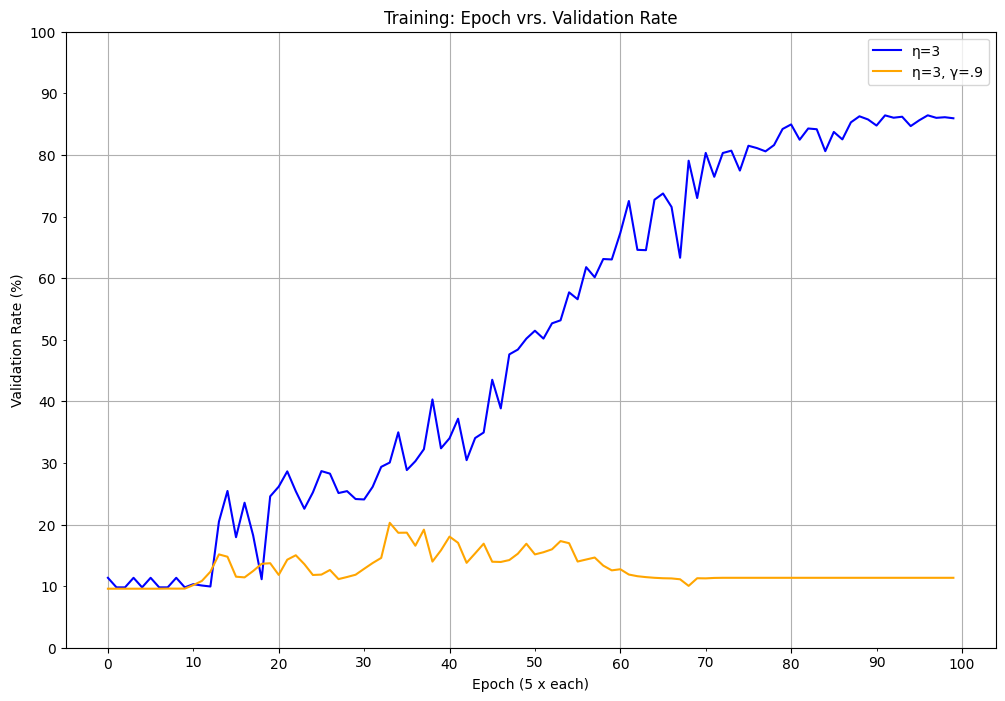

In [ ]:

import numpy as np
import tensorflow as tf
import jax.numpy as jnp
import matplotlib.pyplot as plt 

#TODO: produce help strings 
#TODO: better type annotation
#TODO: implement different initializations 
#TODO: decouple input output from init method in class
#TODO: implement AD with jax 
#TODO: eliminate use of lists , optimize with jax and numba  
#TODO: implement momentum, adam 
#TODO: implement convolutional network 

fire = 1
output_length = 10 

def magnitude(x: np.array) -> (int | float):
    return np.sqrt(np.sum(x**2))
    
def max_normalize(data):
    return data / np.max(data)

def gaussian_normalize(data):
    return (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-8)    
# @nb.jit()


def relu(z):
    return np.maximum(0, z)

def derivative_relu(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z : (int | float)) -> (int | float, np.array):
    """
    Computes the sigmoid of a given input.

    The sigmoid function is commonly used as an activation function in neural networks.

    Parameters:
    -----------
    z : int or float
        The input value for which the sigmoid function will be computed.

    Returns:
    --------
    int or float
        The computed sigmoid value of the input, in the range (0, 1).

    Note:
    -----
    The function expects scalar inputs. For vectorized inputs (e.g., NumPy arrays),
    consider extending this function or directly using vectorized NumPy operations.
    """
    return 1/(1+np.exp(-z))

def derivative_sigmoid(z : (int | float )) -> (int | float, "np.array")  : 
    """
    Computes the derivative of of a given input.

    The sigmoid function is commonly used as an activation function in neural networks.

    Parameters:
    -----------
    z : int or float
        The input value for which the sigmoid function will be computed.

    Returns:
    --------
    int or float
        The computed sigmoid value of the input, in the range (0, 1).

    Note:
    -----
    The function expects scalar inputs. For vectorized inputs (e.g., NumPy arrays),
    consider extending this function or directly using vectorized NumPy operations.
    """
    sig = sigmoid
    return sig(z) * (1-sig(z))


def mse_grad(a:np.array, y:np.array) -> np.array:
    return (a-y)


def hot_encode(x: np.array, output_length:(int | float)) -> np.array:   
    """
    Converts an array of integer indices into one-hot encoded vectors.

    Parameters:
        x (np.array): Array of integer indices.
        output_length (int): Length of the one-hot encoded vectors.

    Returns:
        np.array: A 2D array where each row is a one-hot encoded vector corresponding to the input indices.
    """   
    tmp = []
    for index in x:
        x_vec = np.zeros(output_length)
        x_vec[int(index)] = fire
        tmp.append(x_vec.reshape((output_length)))
    return np.array(tmp)

def feedforward(x: np.array,σ: callable,n: (int | float), W: "NeuralNetwork.weights",b:"NeuralNetwork.bias")-> np.array:
    """
    Perform a feedforward computation in a neural network.

    Parameters
    ----------
    x : np.array
        The input array to the neural network. Typically a vector or batch of vectors.
    σ : callable
        The activation function applied element-wise at each layer (e.g., ReLU, sigmoid, or tanh).
    n : int | float
        The number of layers in the neural network. Assumes layers are indexed from 0 to n-1.
    W : NeuralNetwork.weights
        A list or array of weight matrices, where `W[l]` is the weight matrix for layer `l`.
        Each matrix should have dimensions suitable for the connections between layers.
    b : NeuralNetwork.bias
        A list or array of bias vectors, where `b[l]` is the bias vector for layer `l`.
        Each vector should have dimensions matching the output size of the respective layer.

    Returns
    -------
    np.array
        The output of the neural network after applying all layers.

    Notes
    -----
    - The function assumes that the number of layers (`n`) matches the length of `W` and `b`.
    - The activation function (`σ`) is applied after the affine transformation at each layer:
      `activation = σ(W[l] @ activation + b[l])`.
    - `x` is treated as the initial activation for layer 0.

    Example
    -------
    >>> import numpy as np
    >>> def relu(x):
    ...     return np.maximum(0, x)
    ...
    >>> x = np.array([1, 2])
    >>> W = [np.array([[0.1, 0.2], [0.3, 0.4]]), np.array([[0.5, 0.6]])]
    >>> b = [np.array([0.1, 0.2]), np.array([0.3])]
    >>> feedforward(x, relu, 2, W, b)
    array([0.77])  # Example output
    """
    
    activation = σ(W[0] @ x + b[0])
    for l in range(1, n):
        activation = σ(W[l] @ activation + b[l])

    return activation

def store_intermediate(feedforward):
    """
    Decorator to modify the feedforward method to store intermediate activations.
    
    Parameters
    ----------
    feedforward_func : function
        The original feedforward function to be wrapped.
    
    Returns
    -------
    function
        A new function that stores intermediate activations.
    """
    @wraps(feedforward)
    def wrapper(x, σ, n, W, b):
        # List to store intermediate activations
        A = []
        Z = []
        # Perform the forward pass, storing intermediate activations at each layer
        z0 = W[0] @ x + b[0]
        a0 = σ(z0)
        a = a0
        Z.append(z0);A.append(a0)  # Store the first activation
        for l in range(1, n):
            z = W[l] @ a + b[l]
            a = σ(z)
            Z.append(z);A.append(a)  # Store the activation at each layer
        
        # Call the original feedforward function (return final result)
        result = a
        
        # Return the result and the list of intermediate activations
        return result, A, Z

    return wrapper

def prepare_data(dataset = 'mnist', normalize_scheme=max_normalize):     
        """
    Prepares and preprocesses a dataset for training and testing.

    Parameters:
        dataset (str): Name of the dataset to load from tf.keras.datasets (default: 'mnist').
        normalize_scheme (function): Function to normalize the dataset (default: max_normalize).

    Returns:
        tuple: Preprocessed training and testing data:
            - x_train (np.array): Flattened and normalized training input data.
            - y_train (np.array): One-hot encoded training labels.
            - x_test (np.array): Flattened and normalized testing input data.
            - y_test (np.array): One-hot encoded testing labels.
        """
            # Dynamically get the dataset
        try:
            dataset_module = getattr(tf.keras.datasets, dataset)
        except AttributeError:
            raise ValueError(f"Dataset '{dataset}' not found in tf.keras.datasets")
        (x_train, y_train), (x_test, y_test) = dataset_module.load_data()
        x_train, y_train = np.array(x_train, dtype=float) , np.array(y_train, dtype=float)

        # Take n number of 28*28 matrices and convert them to 784 vectors 
        (r, m, n), (rt, mt, nt) = x_train.shape, x_test.shape
        dim_x, dim_xt = (r, m*n), (rt, mt*nt)
        x_train, x_test = x_train.reshape(dim_x), x_test.reshape(dim_xt)
       
        y_train, y_test = (hot_encode(y_train, output_length),
                           hot_encode(y_test, output_length))

        # normalize datasets 
        # x_train = (x_train - np.mean(x_train, axis=0)) / (np.std(x_train, axis=0) + 1e-8)
        # x_test = (x_test - np.mean(x_test, axis=0)) / (np.std(x_test, axis=0) + 1e-8)
        x_train,  x_test = map(normalize_scheme, [x_train, x_test])

        return x_train, y_train, x_test, y_test

class NeuralNetwork():
    """
    A class for constructing and training a fully connected neural network.

    Attributes:
        input (np.array): Input training data.
        output (np.array): Expected output labels (e.g., one-hot encoded).
        hidden_layer_n (int): Number of hidden layers in the network.
        layer_n (int): Total number of layers (input + hidden + output).
        layer_sizes (np.array): List of sizes for each layer in the network.
        bias (list): List of bias vectors for each layer.
        weights (list): List of weight matrices connecting the layers.
        activation_f (callable): Activation function (default: sigmoid).
        activation_df (callable): Derivative of the activation function.
        cost_function (callable): Cost function for training (if provided).

    Methods:
        train(minibatch=True, minibatch_pool=10, iterations=100, η=1e-6) -> 'NeuralNetwork':
            Trains the neural network using gradient descent.

    Parameters:
        input (np.array): Input training data, where each row is a training example.
        output (np.array): Output labels for the training data.
        hidden_layer (int): Number of hidden layers in the network.
        layer_sizes (list[int | float]): List of hidden layer sizes (default: [10]).
        activation_function (callable): Activation function for all layers (default: sigmoid).
        activation_derivative (callable): Derivative of the activation function (default: derivative_sigmoid).
        cost (callable): Cost function to minimize during training (optional).
        dtype (type): Data type for the network parameters (default: float).

    Train Method Parameters:
        minibatch (bool): Whether to use mini-batch gradient descent (default: True).
        minibatch_pool (int | float): Number of samples per mini-batch (default: 10).
        iterations (int | float): Number of training iterations (default: 100).
        η (int | float): Learning rate for gradient descent (default: 1e-6).

    Returns:
        NeuralNetwork: The trained neural network object.

    Example:
        nn = NeuralNetwork(input=x_train, 
                           output=y_train, 
                           hidden_layer=2, 
                           layer_sizes=[64, 32], 
                           activation_function=sigmoid, 
                           activation_derivative=derivative_sigmoid)
        nnSGD(minibatch=True, minibatch_pool=32, iterations=1000, η=0.01)
    """

    def __init__(self,
                 layer_sizes: (list[int] | list[float]) = [10] ,
                 distribution: callable = np.random.randn, 
                 initialization_scheme: callable = None ,  
                 activation_function: callable = sigmoid, 
                 activation_derivative: callable = derivative_sigmoid,
                 cost_function: callable = None, 
                 cost_grad: callable = mse_grad) -> 'NeuralNetwork':
        
        self.layer_sizes = layer_sizes
        self.layer_n = len(self.layer_sizes)
        self.hidden_layer_n = len(self.layer_sizes)-2
        self.bias = [distribution(self.layer_sizes[i])
                     for i in range(1, self.hidden_layer_n+2)] 
    
        self.weights = [distribution(self.layer_sizes[i], 
                                          self.layer_sizes[i-1]) * np.sqrt(1/self.layer_sizes[i-1])
                        for i in range(1, self.hidden_layer_n+2)]
        
        self.activation_f = activation_function
        self.activation_df= activation_derivative
        self.cost = cost_function
        self.cost_grad = cost_grad


    def train(self,
              input, 
              output, 
              momentum: (int | float) = None, 
              minibatch: bool = True,
              minibatch_pool : (int | float) = 10,
              iterations: (int | float) = 100,
              η: (int | float) = 1e-6) -> None:
        """
    Trains the neural network using gradient descent.

    Parameters:
        minibatch (bool): Whether to use mini-batch gradient descent (default: True).
        minibatch_pool (int | float): Size of the mini-batch for training (default: 10).
        iterations (int | float): Number of training iterations (default: 100).
        η (int | float): Learning rate for gradient descent (default: 1e-6).

    Returns:
        NeuralNetwork: The trained neural network object.

    Description:
        - Implements forward propagation for each input to compute activations.
        - Performs backpropagation to compute gradients for weights and biases.
        - Updates weights and biases using gradient descent.
        - Supports mini-batch gradient descent if `minibatch` is set to True.

    Example:
        nn.train(minibatch=True, minibatch_pool=32, iterations=1000, η=0.01)
        """
        
        for _ in range(iterations):

            if minibatch:
                indexes = np.random.choice(input.shape[0], size=minibatch_pool)
                X, Y = input[indexes], output[indexes]
            else: 
                X, Y = input, output


            a_errors = [np.zeros(matrix.shape) for matrix in self.weights]

            b_errors = [np.zeros(vector.shape) for vector in self.bias]

            # iterate for each set of x and y
            # find zs and as (pre-act and activation)
            for x, y in zip(X, Y): 
                # print("x id:",id(x))
                z0 = self.weights[0] @ x + self.bias[0]
                zs = [z0]
                a0 = self.activation_f(z0)
                activations = [a0]
                for l in range(1, self.layer_n-1,1):
                    # print("layers:",l,l-1)
                    zl = self.weights[l] @ activations[l-1] + self.bias[l]
                    activation = self.activation_f(zl)
                    # print("activation:", activation)
                    zs.append(zl)
                    activations.append(activation)  

                z_output = zs[-1]
                a_output = activations[-1]
                output_error = self.cost_grad(a_output,y) * self.activation_df(z_output)
                errors = [output_error]
                for l in range(self.hidden_layer_n, 0, -1):
                    error = self.weights[l].T @ errors[-1] * self.activation_df(zs[l-1])
                    errors.append(error)

                errors.reverse()
                # compute sum of error
                for l in range(0,self.hidden_layer_n+1,1):
                    # a_errors[l] += errors[l]@activations[l].T
                    a_errors[l] += np.outer(errors[l], activations[l-1]  if l > 0 else x)
                    # print(a_errors)
                    b_errors[l] += errors[l] 
                        # print(b_errors)


            if momentum == None: 
                for l in range(0, self.hidden_layer_n+1):
                    self.weights[l] -= η / minibatch_pool * a_errors[l]
                    self.bias[l] -= η / minibatch_pool * b_errors[l]
            else: 
                γ = momentum 
                v = [ np.zeros(w.shape) for w in self.weights ]
                for l in range(0, self.hidden_layer_n+1):
                    v[l] = γ * v[l] + η / minibatch_pool * a_errors[l]
                    self.weights[l] -= v[l]
                    self.bias[l] -= η / minibatch_pool * b_errors[l]


    def predict(self, 
                input: list[np.array]) -> list[np.array]:
        
        """
    Predicts the output for a given input using the trained neural network.

    Parameters:
        input (np.array): Input data to predict, where each row corresponds to a single input instance.

    Returns:
        list: A list of predictions where each prediction corresponds to the output of the neural network
              for the corresponding input instance.

    Description:
        - Performs forward propagation through the network to compute the output layer activations.
        - Returns the final layer activations as predictions.

    Example:
        predictions = nn.predict(x_test)
        """
        
        results = [ ]
        for x in input : 
            # print(x,"\n")
            z0 = self.activation_f(self.weights[0] @ x + self.bias[0])
            activations = [z0]
            for l in range(1, self.layer_n-1):
                zl = self.weights[l] @ activations[l-1] + self.bias[l]
                a = self.activation_f(zl)
                activations.append(a) 
        
            results.append(activations[-1])

        return results
    
if __name__ == "__main__":
 
    x_train, y_train, x_test, y_test = prepare_data()
    input_n = x_train.shape[1]
    output_n = y_train.shape[1]

    # net = NeuralNetwork([input_n,128, 64,output_n],
    #                     cost_grad=lambda a, y: (a-y)/(a*(1-a)),
    #                     activation_derivative=lambda a: a*(1-a))
    

    nn_sgd = NeuralNetwork([input_n,128, 64,output_n])
    nn_sgd_w_momentum = NeuralNetwork([input_n,256, 128,output_n])

    # net = NeuralNetwork([input_n,128, 64, output_n])

    validation_rate_sgd, validation_rate_momentum = [], []

    for run in range(0,100):
        nn_sgd.train(x_train,y_train,minibatch_pool=64,iterations=5,η=3)
        nn_sgd_w_momentum.train(x_train,y_train,minibatch_pool=64,iterations=5,η=3, momentum=.9)

        result_sgd = nn_sgd.predict(x_test)
        result_sgd_w_momentum = nn_sgd_w_momentum.predict(x_test)
        rate_sgd = np.sum(np.array(list(map(np.argmax,result_sgd))) == np.array(list(map(np.argmax,y_test))))
        rate_momentum = np.sum(np.array(list(map(np.argmax,result_sgd_w_momentum))) == np.array(list(map(np.argmax,y_test))))
        validation_rate_sgd.append(rate_sgd/len(x_test)*100)
        validation_rate_momentum.append(rate_momentum/len(x_test)*100)
    
    plt.figure(figsize=(12,8))
    plt.plot(validation_rate_sgd, label=r"η=3",  color="blue")
    plt.plot(validation_rate_momentum, label=r"η=3, γ=.9",  color="orange")
    plt.title(r"Training: Epoch vrs. Validation Rate")
    plt.xlabel("Epoch (5 x each)")
    plt.ylabel("Validation Rate (%)")
    x_ticks = np.arange(0,101,10)
    y_ticks = np.arange(0,101,10)
    plt.xticks(x_ticks,labels=x_ticks.astype(str), minor=True)
    plt.yticks(y_ticks,labels=y_ticks.astype(str), minor=True)
    plt.grid()
    plt.legend()
    plt.show()

In [78]:
max(validation_rate_momentum)


np.float64(70.12)